# Random Down-Sampling

Random down-sampling diminishes the volume of revealed data used for forecasting prospectivity probability. When applying random down-sampling, the degree of confidentiality will be evaluated in relation to the down-sampling proportion. To enhance dependability, execute a sequence of n (with n is set to 50) distinct iterations to compile mean results and include error bars.

### Figure 21 and 22 : Prospectivity heatmap of random down-sampling

'Random down-sampling (5.0%) '

233it [00:50,  4.59it/s]
233it [00:00, 4186.88it/s]


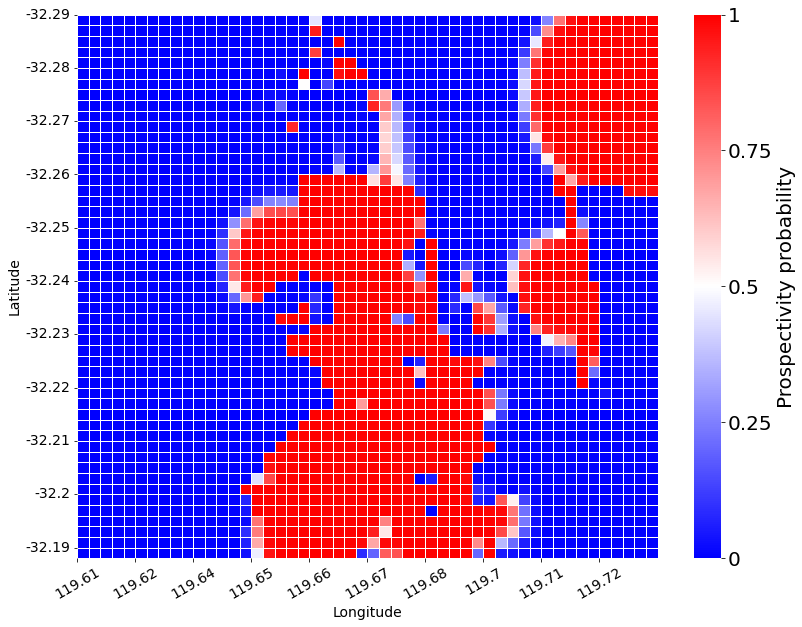

In [6]:
# Import necessary libraries and modules
import shapely
import warnings
import os
import numpy as np
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
np.warnings.filterwarnings('ignore')
import sys

sys.path.append('..')

from minerals import *

# Function to display heatmap graph
def display_graph2(axi, df, tenid, tit):
    df['proba' + tenid] = df['proba_prospectivity_' + tenid] * 2

    a = []
    text_a = []
    for y in sorted(np.unique(df.coords_y.tolist()), reverse=True):
        ll = []
        text_ll = []
        for x in sorted(np.unique(df.coords_x.tolist())):
            ll.append(df[(df.coords_x == x) & (df.coords_y == y)]['proba' + tenid].values[0])

        a.append(ll)

    q = sns.heatmap(a, fmt="", linewidth=0.5, center=1, ax=axi, cmap='bwr')

    if len(df) > 1000:
        step = 5
    else:
        step = 4

    xlab = sorted([round(x, 2) for x in np.unique(df.coords_x.tolist())])
    lx = np.arange(len(xlab))
    axi.tick_params(axis='x', labelsize=14, rotation=30)
    axi.set(xticks=lx[0::step], xticklabels=xlab[0::step])

    ylab = sorted([round(x, 2) for x in np.unique(df.coords_y.tolist())])
    ly = np.arange(len(ylab))
    axi.tick_params(axis='y', labelsize=14, rotation=0)
    axi.set(yticks=ly[0::step], yticklabels=ylab[0::step])

    axi.set_xlabel('Longitude', fontsize=14)
    axi.set_ylabel('Latitude', fontsize=14)

    q.collections[0].colorbar.set_ticks([0, 0.5, 1, 1.5, 2])
    q.collections[0].colorbar.set_ticklabels(['0', '0.25', '0.5', '0.75', '1'])
    q.collections[0].colorbar.ax.tick_params(labelsize=20)
    axi.collections[0].colorbar.set_label("Prospectivity probability", size=20)


# Define paths and parameters
path = '..'
side_len = 50
l = 5

# Load data and prepare the mineral grid
df = read_files(path)
df_minerals_grid = pd.read_csv('../data/df_minerals_grid_' + str(side_len) + '_v2.csv')
df_sampling_tenement = pd.read_csv('../data/df_sampling_tenement_' + str(side_len) + '_v2.csv')

# Sort mineral grid and calculate additional columns
df_minerals_grid = df_minerals_grid.sort_values(by=['coords_x', 'coords_y'], ignore_index=True)
df_minerals_grid['proba_prospectivity_orig'] = df_minerals_grid['proba_prospectivity-40']
df_minerals_grid['abs_error_orig'] = 0

# Import random and define directories
import random
import os
import gc
cols = ['coords_x', 'coords_y', 'proba_prospectivity-40', 'tenements']
l = 5
directory1 = path + '/data_' + str(side_len) + '/out_l=' + str(l)

# Load the mineral grid again for processing
df_minerals_grid = pd.read_csv('../data/df_minerals_grid_' + str(side_len) + '_v2.csv')
df_minerals_grid['proba_prospectivity_orig-40'] = df_minerals_grid['proba_prospectivity-40']
df_minerals_grid['abs_error_orig'] = 0

# Create an empty DataFrame to store results
dfe = pd.DataFrame()

# Iterate through runs and ratios
for n in range(50):
    for ratio in np.arange(0.05, 0.35, .05):

        dico_metrics = {}
        dico_metrics['n'] = n
        tenement_id = 'random_' + str(int()) + '_n=' + str(n)
        tit = 'Random down-sampling (' + str(int(ratio * 100)) + '%) '
        print (tit)
        dico_metrics['ratio'] = ratio * 100

        # Generate a list of randomly sampled samples
        list_random_sampling = random.sample(df_sampling_tenement['sample'].values.tolist(),
                                             int(len(df_sampling_tenement) * ratio))
        conf_loss_count = (len(df_sampling_tenement) - len(list_random_sampling)) / len(df_sampling_tenement)

        # Calculate the resulting utility loss after down-sampling
        df_res = remove_and_recalculate_prospectivy(df, df_minerals_grid, tenement_id, directory1, list_random_sampling)

        df_res = df_res.sort_values(by=['coords_x', 'coords_y'], ignore_index=True)
        df_res['abs_error_' + tenement_id.replace(' ', '')] = (
                    df_res['proba_prospectivity_orig-40'] - df_res['proba_prospectivity-40']).abs()
        df_res = df_res.rename(columns={'proba_prospectivity_orig-40': 'proba_prospectivity_orig',
                                        'proba_prospectivity-40': 'proba_prospectivity_' + tenement_id.replace(' ',
                                                                                                               '')})

        tit += 'Conf_loss_count=' + str(round(conf_loss_count, 3)) + '\n'
        dico_metrics['Conf_loss_count'] = conf_loss_count

        # Calculate utility loss for different levels of analysis
        for l in [5, 10, 15, 20, 30, 50, 80]:
            klargest_errors = df_res['abs_error_' + tenement_id.replace(' ', '')].nlargest(l).values
            meanerr = str(round(np.mean(klargest_errors), 3))
            tit += "loss_MAE-" + str(l) + "=" + meanerr + ' '
            dico_metrics['loss_MAE-' + str(l)] = np.mean(klargest_errors)

        # Append the results to the DataFrame
        dfe = dfe.append(dico_metrics, ignore_index=True)
        print (dfe)

        # Save the DataFrame to a CSV file
        dfe.to_csv('dfe.csv', index=False)


#  Compare L-values

### Figure 23: Utility loss measured by top-𝐿 mean absolute error of random down-sampling with various values of down- sampling percentage and 𝐿.

,n,ratio,Conf_loss_count,loss_MAE-5,loss_MAE-10,loss_MAE-15,loss_MAE-20,loss_MAE-30,loss_MAE-50,loss_MAE-80
0,0.0,5.0,0.95,0.998163,0.995492,0.988082,0.971371,0.812978,0.495148,0.309494
1,1.0,5.0,0.95,0.882363,0.511549,0.344789,0.259173,0.172846,0.103709,0.064818
2,2.0,5.0,0.95,0.999913,0.999693,0.999040,0.997403,0.961429,0.659680,0.413759
3,3.0,5.0,0.95,0.999929,0.999736,0.999254,0.998670,0.994188,0.833158,0.545607
4,4.0,5.0,0.95,0.985419,0.904972,0.785100,0.650522,0.454553,0.280096,0.175807


,n,Conf_loss_count,loss_MAE-5,loss_MAE-10,loss_MAE-15,loss_MAE-20,loss_MAE-30,loss_MAE-50,loss_MAE-80
ratio,,,,,,,,,
5.0,29.500000,0.95,0.911731,0.801911,0.715480,0.646879,0.546477,0.420135,0.321463
10.0,24.181818,0.90,0.992666,0.963697,0.928658,0.884555,0.806134,0.693538,0.582118
15.0,24.500000,0.85,0.998194,0.989299,0.977481,0.962814,0.929239,0.852044,0.739917
20.0,24.500000,0.80,0.999178,0.997250,0.992953,0.986225,0.963831,0.912408,0.822084
25.0,25.103448,0.75,0.999910,0.999669,0.998889,0.997516,0.993205,0.976315,0.932209
30.0,24.500000,0.70,0.999979,0.999892,0.999744,0.999390,0.997814,0.988801,0.975809


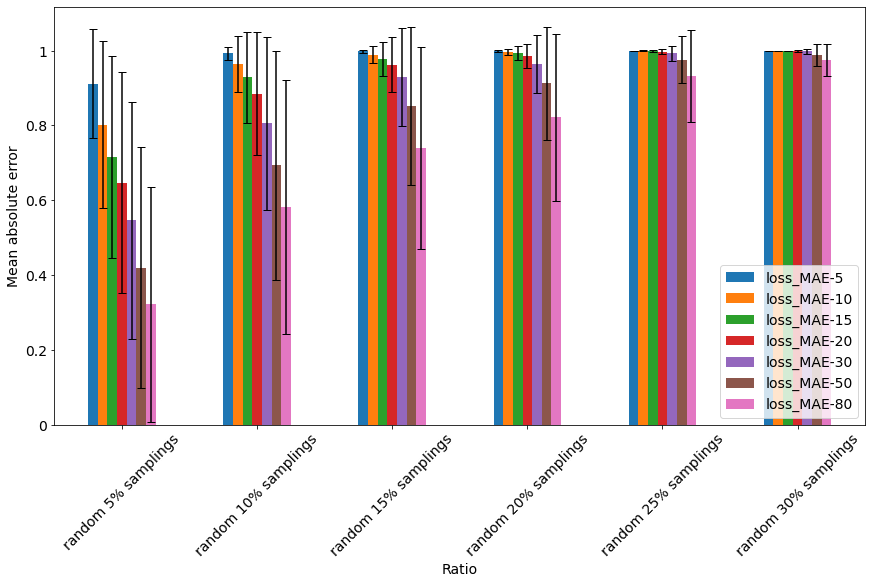

In [7]:
import pandas  as pd
import gc
import numpy as np

df_err = pd.read_csv('../tests/dfe.csv')
display(df_err.head())
meanerrs = df_err.groupby('ratio').mean()
display(meanerrs)
names_xticks= []
for ratio in [0.05,0.1,0.15,0.2,0.25, 0.3]:
    names_xticks.append('random '+str(int(ratio*100))+'% samplings')
    
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12,8),constrained_layout=True)

meanerrs[['loss_MAE-'+str(l) for l in [5,10,15,20,30,50,80]]].plot(kind='bar',
        yerr=np.transpose(df_err.groupby('ratio').std()[['loss_MAE-'+str(l) for l in [5,10,15,20,30,50,80]]].to_numpy()),
        align='center',
       ecolor='black',
       capsize=4,ax =ax, fontsize=14)

ax.set_ylabel('Mean absolute error', fontsize=14)
ax.set_xlabel('Ratio', fontsize=14)
ax.legend(fontsize=14)
#ax.set_xticks( rotation=45, ha='right')
ax.set_yticklabels([0,0.2,0.4,0.6,0.8, 1] ,fontsize=14)

ax.set_xticklabels(names_xticks, rotation=45, fontsize=14)
plt.savefig('../img_may2023/fig23_histogram_random.png')
plt.show()